In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from google.colab import files

In [2]:
uploaded = files.upload()

Saving sentiment.csv to sentiment.csv


In [3]:

# Load dataset
df = pd.read_csv('sentiment.csv')

# Turn '?' and empty strings into NaN
df.replace(['?', ''], np.nan, inplace=True)

In [4]:
# Calculate missing values and percentages
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df)) * 100

# Combine into a single summary table
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing Percentage (%)': missing_percentages.round(2)
}).sort_values(by='Missing Values', ascending=False)

# Display the summary
print(missing_summary)


                       Missing Values  Missing Percentage (%)
embedded_content_url            30757                   76.89
profile_picture                 12271                   30.68
sentiment                         527                    1.32
post_datetime                     507                    1.27
timezone                          507                    1.27
posts_retweets                    486                    1.21
post_likes                        486                    1.21
email                             480                    1.20
username                          480                    1.20
followers                         480                    1.20
birthday                          480                    1.20
account_creation_date             480                    1.20
checkmark                         480                    1.20
previous_posts_count              480                    1.20
id                                  0                    0.00
text    

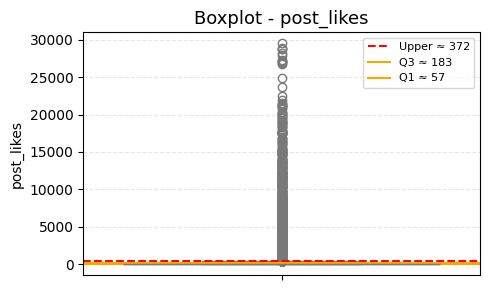

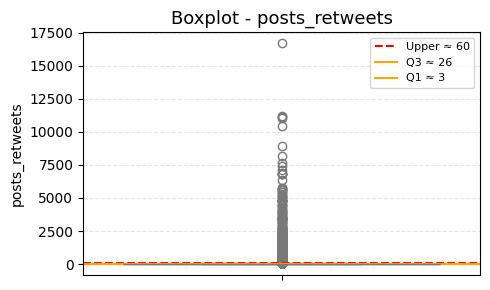

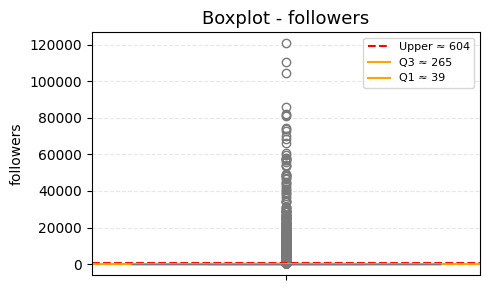

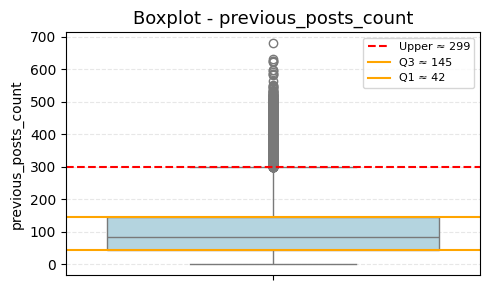

In [5]:
# Utility: clean selected columns before plotting
def clean_for_plot(df, columns):
    df_temp = df.copy()
    df_temp = df_temp.dropna(subset=columns)

    for col in columns:
        if col == 'sentiment':
            df_temp[col] = df_temp[col].astype(str).str.strip().str.lower()
            df_temp = df_temp[df_temp[col].isin(['positive', 'negative'])]
        else:
            df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')

    return df_temp.dropna(subset=columns)

# Utility: plot a boxplot with outlier thresholds
def box_plot_with_thresholds(df, column, color='lightblue'):
    plt.figure(figsize=(5, 3))  # Slightly bigger so it won't look too squeezed
    sns.boxplot(y=df[column], color=color)

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr

    plt.axhline(upper, color='red', linestyle='--', label=f'Upper ≈ {int(upper)}')
    plt.axhline(q3, color='orange', linestyle='-', label=f'Q3 ≈ {int(q3)}')
    plt.axhline(q1, color='orange', linestyle='-', label=f'Q1 ≈ {int(q1)}')

    plt.title(f"Boxplot - {column}", fontsize=13)
    plt.ylabel(column, fontsize=10)
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Boxplots for selected columns
columns_to_plot = ['post_likes', 'posts_retweets', 'followers', 'previous_posts_count']

for col in columns_to_plot:
    df_clean = clean_for_plot(df, [col])
    box_plot_with_thresholds(df_clean, col)


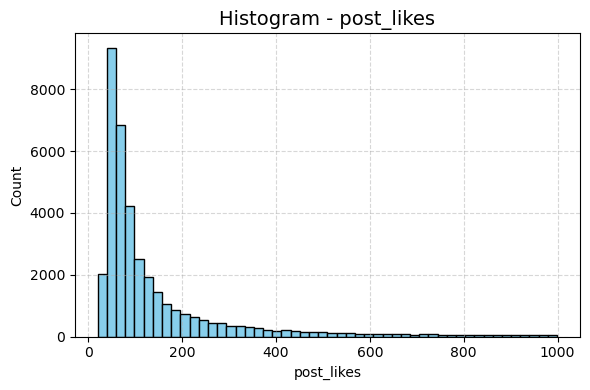

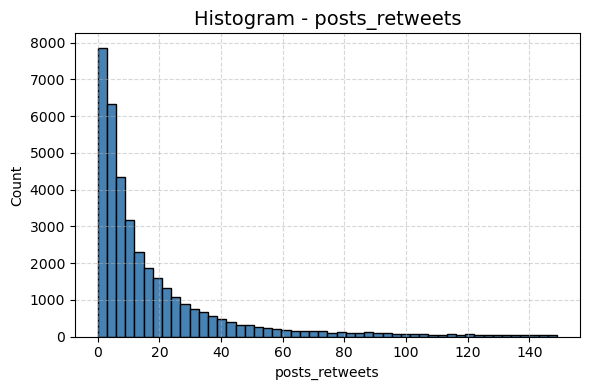

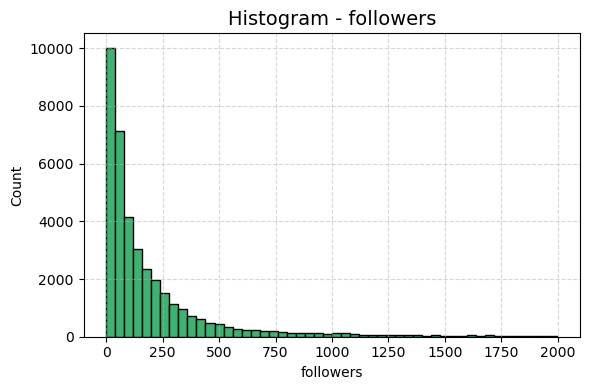

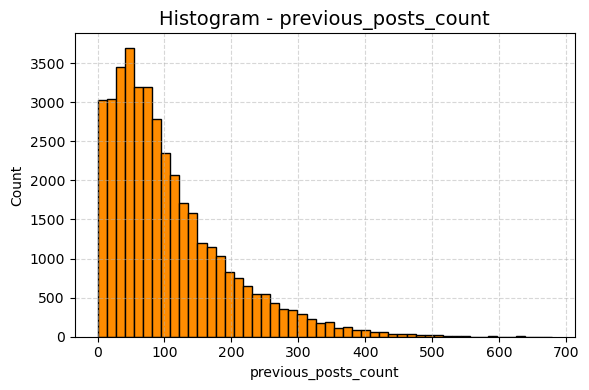

In [ ]:
# Utility: plot a simple histogram
def plot_histogram(df, column, color='skyblue', x_limit=None):
    data = df[column].dropna()

    if x_limit is not None:
        data = data[data < x_limit]

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=50, color=color, edgecolor='black')
    plt.title(f"Histogram - {column}", fontsize=14)
    plt.xlabel(column, fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Histograms for selected columns
histogram_columns = [
    ('post_likes', 1000, 'skyblue'),
    ('posts_retweets', 150, 'steelblue'),
    ('followers', 2000, 'mediumseagreen'),
    ('previous_posts_count', None, 'darkorange')
]

for col, limit, color in histogram_columns:
    df_clean = clean_for_plot(df, [col])  # small clean per column
    plot_histogram(df_clean, col, color=color, x_limit=limit)


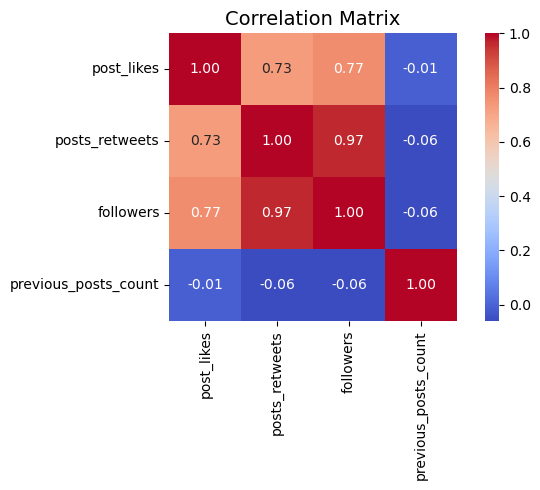

In [ ]:
# Utility: plot a correlation heatmap
def plot_correlation_matrix(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(7, 5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', square=True, fmt='.2f')
    plt.title("Correlation Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()

# Columns we want for correlation analysis
numeric_columns = ['post_likes', 'posts_retweets', 'followers', 'previous_posts_count']

# Plot the correlation matrix
df_corr = clean_for_plot(df, numeric_columns)
plot_correlation_matrix(df_corr, numeric_columns)


        Feature    Weight Sentiment  Frequency %  Positive % when appears
19   passionate  5.124239  Positive         0.74                    98.28
18   supporting  5.094483  Positive         0.66                    98.47
17     generous  4.847812  Positive         0.62                    97.14
16        sweet  3.894128  Positive         0.91                    91.67
15     accepted  3.860391  Positive         0.78                    92.18
14      blessed  3.515975  Positive         0.83                    93.25
13     positive  2.860053  Positive         0.63                    85.94
12    wonderful  2.488915  Positive         0.60                    85.71
11    important  2.464955  Positive         0.73                    84.67
10      amazing  2.385499  Positive         0.58                    84.28
9         loved  2.117397  Positive         0.80                    78.55
8       excited  2.080904  Positive         0.73                    77.51
7          feel  1.760961  Positive   

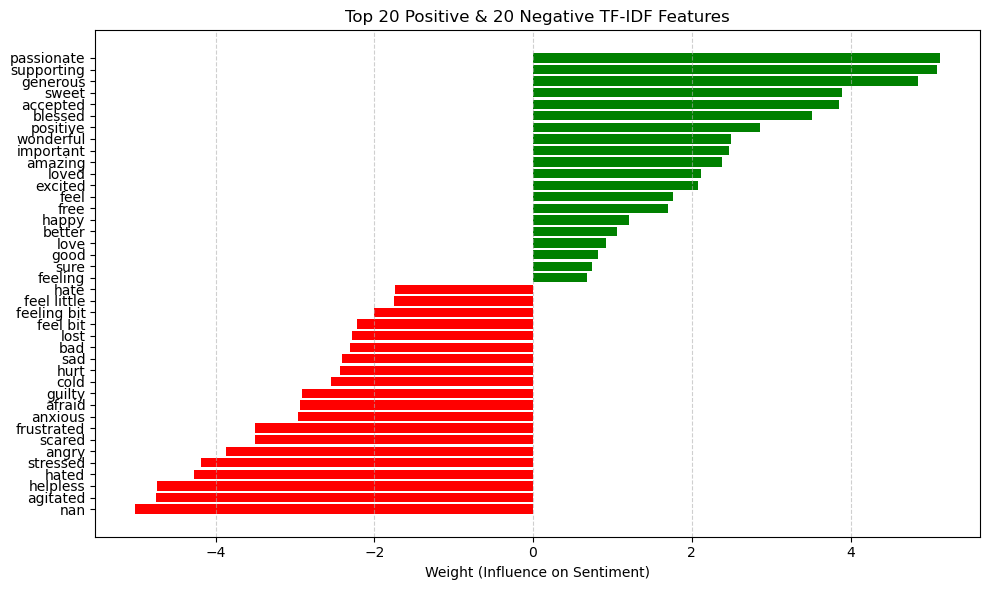

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df_clean = df[df['sentiment'].isin(['positive', 'negative'])].copy()

# TF-IDF matrix
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=200)
X = vectorizer.fit_transform(df_clean['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()
y = df_clean['sentiment'].map({'positive': 1, 'negative': 0})
model = LogisticRegression(max_iter=1000)
model.fit(X, y)
coefs = model.coef_[0]

# Select top positive and negative features
top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]
selected_idx = np.concatenate([top_pos_idx, top_neg_idx])

selected_features = feature_names[selected_idx]
selected_weights = coefs[selected_idx]

# Feature stats
binary_matrix = (X[:, selected_idx] > 0).toarray()
feature_stats = []

for i, feature in enumerate(selected_features):
    present_rows = binary_matrix[:, i] == 1
    total_presence = present_rows.sum()
    pos_presence = y[present_rows].sum()

    freq = total_presence / len(y)
    pos_ratio = pos_presence / total_presence if total_presence > 0 else 0
    sentiment = "Positive" if selected_weights[i] > 0 else "Negative"

    feature_stats.append({
        'Feature': feature,
        'Weight': selected_weights[i],
        'Sentiment': sentiment,
        'Frequency %': round(freq * 100, 2),
        'Positive % when appears': round(pos_ratio * 100, 2)
    })

df_summary = pd.DataFrame(feature_stats).sort_values(by='Weight', ascending=False)

# Show table
print(df_summary)

# Plot
plt.figure(figsize=(10, 6))
colors = ['green' if s == "Positive" else 'red' for s in df_summary['Sentiment']]
plt.barh(df_summary['Feature'], df_summary['Weight'], color=colors)
plt.xlabel("Weight (Influence on Sentiment)")
plt.title("Top 20 Positive & 20 Negative TF-IDF Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


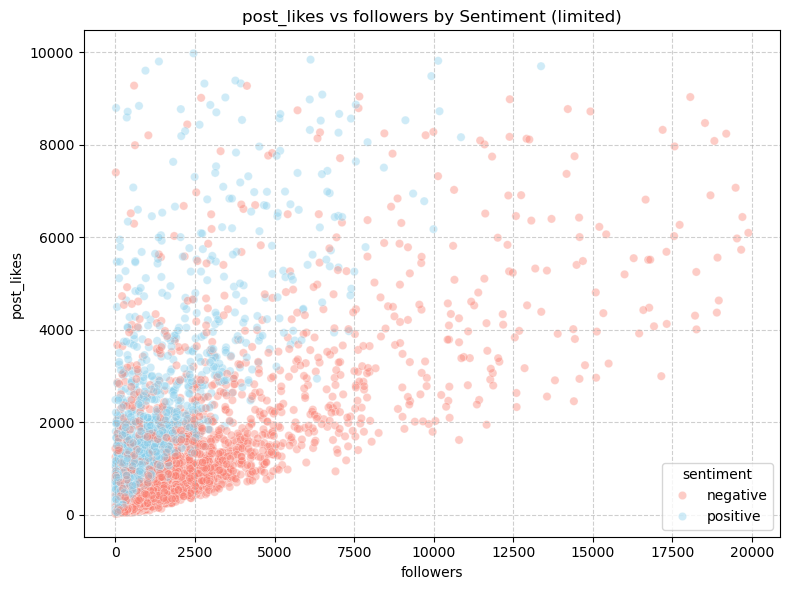

In [ ]:
def plot_scatter_by_sentiment_limited(df, x, y, x_max=None, y_max=None):
    df_clean = clean_for_plot(df, [x, y, 'sentiment'])
    if x_max is not None:
        df_clean = df_clean[df_clean[x] < x_max]
    if y_max is not None:
        df_clean = df_clean[df_clean[y] < y_max]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_clean, x=x, y=y, hue='sentiment', alpha=0.4, palette={'positive': 'skyblue', 'negative': 'salmon'})
    plt.title(f"{y} vs {x} by Sentiment (limited)")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_scatter_by_sentiment_limited(df, x='followers', y='post_likes', x_max=20000, y_max=10000)


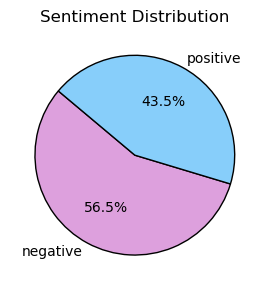

In [ ]:
# Plot a pie chart of sentiment distribution
def plot_sentiment_pie(df):
    df_valid = df[df['sentiment'].isin(['positive', 'negative'])]
    sentiment_counts = df_valid['sentiment'].value_counts()

    plt.figure(figsize=(3, 3))
    plt.pie(sentiment_counts,
            labels=sentiment_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=['plum', 'lightskyblue'],
            wedgeprops={'edgecolor': 'black'})

    plt.title('Sentiment Distribution', fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function
plot_sentiment_pie(df)


In [ ]:

def plot_percentage_stacked_bar(df, category_column, title=None, order=None):
    # Clean data
    df_clean = df[[category_column, 'sentiment']].dropna()
    df_clean = df_clean[df_clean['sentiment'].isin(['positive', 'negative'])]

    # Calculate percentages
    prop_df = (
        df_clean.groupby([category_column, 'sentiment'])
        .size()
        .unstack(fill_value=0)
        .apply(lambda x: x / x.sum() * 100, axis=1)
    )
    if order:
        prop_df = prop_df.loc[order]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['lightcoral', 'lightblue']
    prop_df.plot(
        kind='bar',
        stacked=True,
        color=colors,
        edgecolor='black',
        ax=ax
    )

    # Add percentage labels inside bars
    for i, row in enumerate(prop_df.values):
        cumulative = 0
        for j, val in enumerate(row):
            if val > 0:
                ax.text(i, cumulative + val / 2, f'{val:.1f}%', ha='center', va='center', fontsize=7)
            cumulative += val

    # Improve x-axis
    ax.set_xticklabels(prop_df.index, rotation=45, ha='right')
    ax.set_xlabel(category_column.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(title or f'Sentiment by {category_column.replace("_", " ").title()}', fontsize=12)
    ax.legend(title='Sentiment', loc='upper right')

    # If too many ticks, show only every 2nd or 3rd year
    if len(prop_df.index) > 20:
        every_n = 2
    else:
        every_n = 1
    ax.set_xticks(np.arange(len(prop_df.index))[::every_n])
    ax.set_xticklabels(prop_df.index[::every_n], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


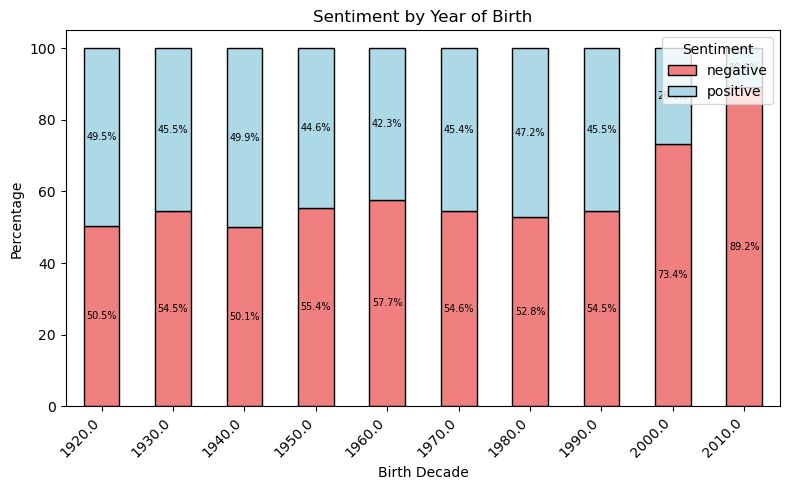

In [ ]:
# Create birth_decade feature
df['birthday'] = pd.to_datetime(df['birthday'], errors='coerce')
df['birth_year'] = df['birthday'].dt.year
df['birth_decade'] = (df['birth_year'] // 10) * 10

# Plot sentiment distribution by birth decade
plot_percentage_stacked_bar(
    df,
    category_column='birth_decade',
    title='Sentiment by Year of Birth'
)

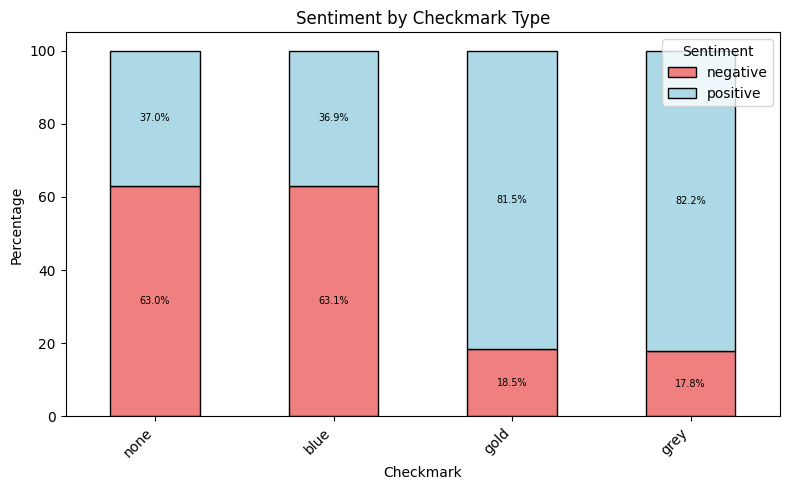

In [ ]:
# Plot sentiment distribution by checkmark type
checkmark_values = ['none', 'blue', 'gold', 'grey']

plot_percentage_stacked_bar(
    df[df['checkmark'].isin(checkmark_values)],
    category_column='checkmark',
    title='Sentiment by Checkmark Type',
    order=checkmark_values
)

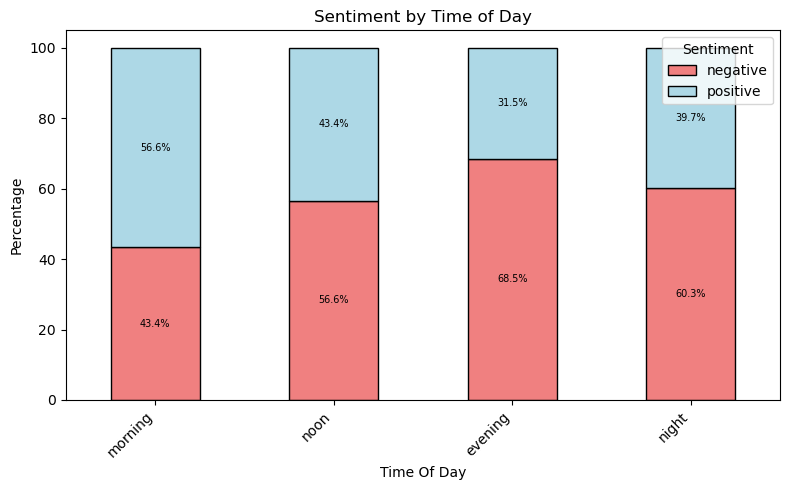

In [ ]:
# Map timezones to UTC offsets
timezone_map = {
    'UTC': 0, 'GMT': 0, 'CET': 1, 'EET': 2, 'MSK': 3,
    'EST': -5, 'PST': -8, 'AEST': 10, 'KST': 9, 'JST': 9
}

df['timezone_offset'] = df['timezone'].map(timezone_map)

# Calculate local post hour
df['post_datetime'] = pd.to_datetime(df['post_datetime'], errors='coerce')
df['utc_hour'] = df['post_datetime'].dt.hour
df['local_hour'] = (df['utc_hour'] + df['timezone_offset']) % 24

# Classify time of day
def classify_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'noon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['local_hour'].apply(classify_time)

# Plot sentiment by time of day
plot_percentage_stacked_bar(
    df,
    category_column='time_of_day',
    title='Sentiment by Time of Day',
    order=['morning', 'noon', 'evening', 'night']
)

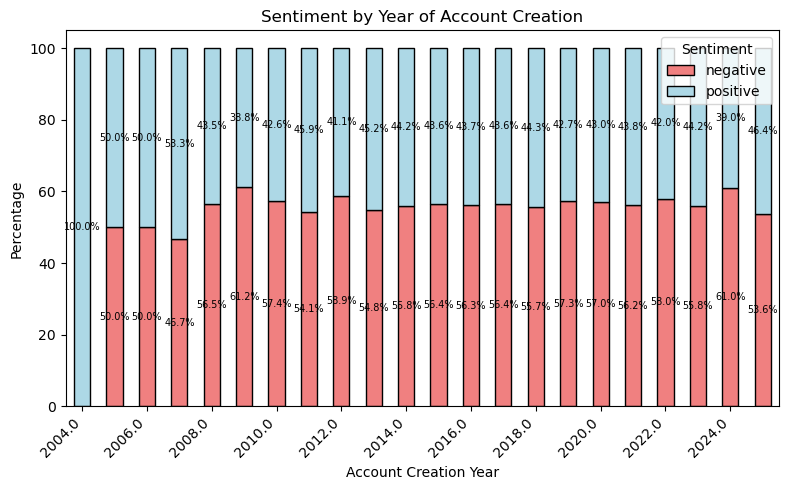

In [ ]:
# Extract account creation year and decade
df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')
df['account_creation_year'] = df['account_creation_date'].dt.year
df['account_creation_decade'] = (df['account_creation_year'] // 10) * 10

# Plot sentiment distribution by account creation year
plot_percentage_stacked_bar(
    df,
    category_column='account_creation_year',
    title='Sentiment by Year of Account Creation'
)


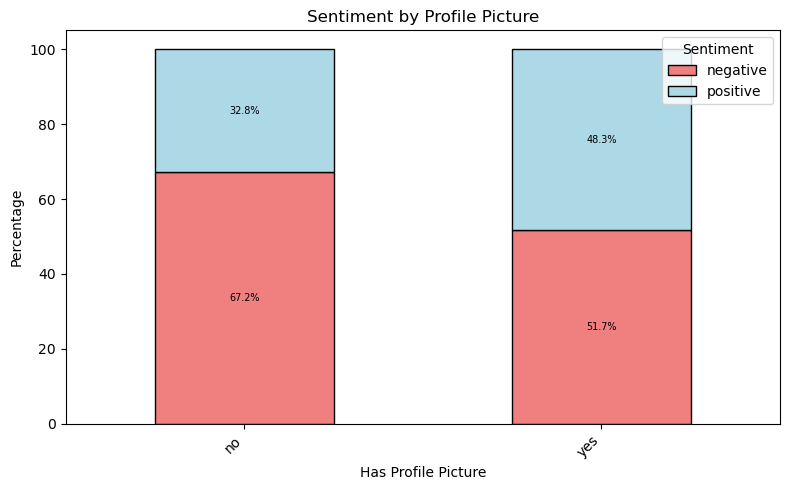

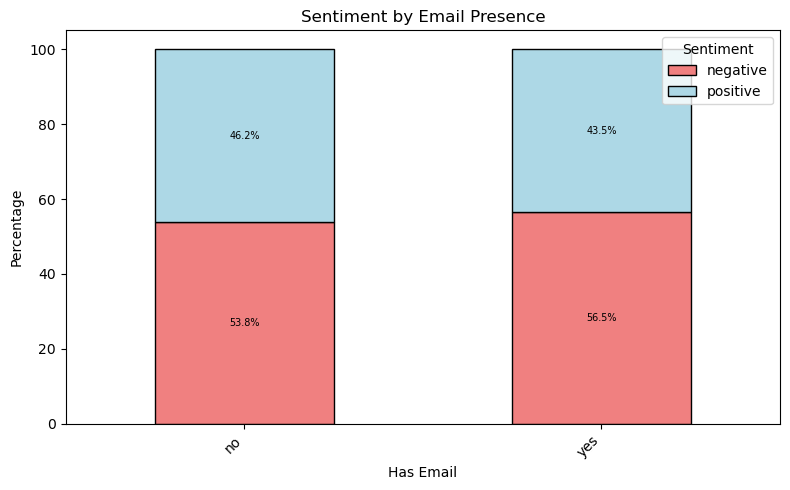

In [ ]:
# Create 'has_profile_picture' feature
df['has_profile_picture'] = df['profile_picture'].apply(
    lambda x: 'yes' if isinstance(x, str) and x.strip() != '' else 'no'
)

# Plot sentiment distribution by profile picture presence
plot_percentage_stacked_bar(
    df,
    category_column='has_profile_picture',
    title='Sentiment by Profile Picture',
    order=['no', 'yes']
)

# Create 'has_email' feature
df['has_email'] = df['email'].apply(
    lambda x: 'yes' if isinstance(x, str) and '@' in x and '.' in x else 'no'
)

# Plot sentiment distribution by email presence
plot_percentage_stacked_bar(
    df,
    category_column='has_email',
    title='Sentiment by Email Presence',
    order=['no', 'yes']
)

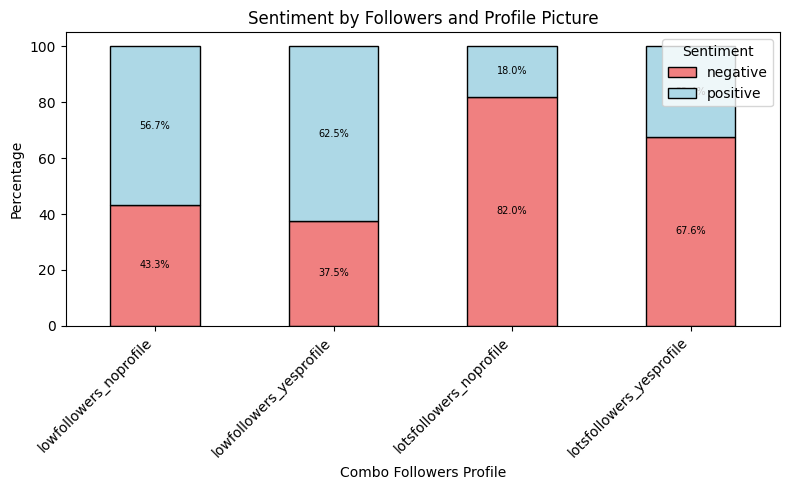

In [ ]:
# Convert relevant columns to numeric
df['previous_posts_count'] = pd.to_numeric(df['previous_posts_count'], errors='coerce')
df['followers'] = pd.to_numeric(df['followers'], errors='coerce')

# Create 'has_profile_picture' feature
df['has_profile_picture'] = df['profile_picture'].apply(
    lambda x: 'yes' if isinstance(x, str) and x.strip() != '' else 'no'
)

# Create 'few_followers' feature (less than 100 followers)
df['few_followers'] = df['followers'].apply(
    lambda x: 'lowfollowers' if pd.notnull(x) and x < 100 else 'lotsfollowers'
)

# Build combo column combining follower status and profile picture
df['combo_followers_profile'] = df['few_followers'] + '_' + df['has_profile_picture'].map({'yes': 'yesprofile', 'no': 'noprofile'})

# Plot the stacked percentage bar chart
plot_percentage_stacked_bar(
    df,
    category_column='combo_followers_profile',
    title='Sentiment by Followers and Profile Picture',
    order=[
        'lowfollowers_noprofile',
        'lowfollowers_yesprofile',
        'lotsfollowers_noprofile',
        'lotsfollowers_yesprofile'
    ]
)


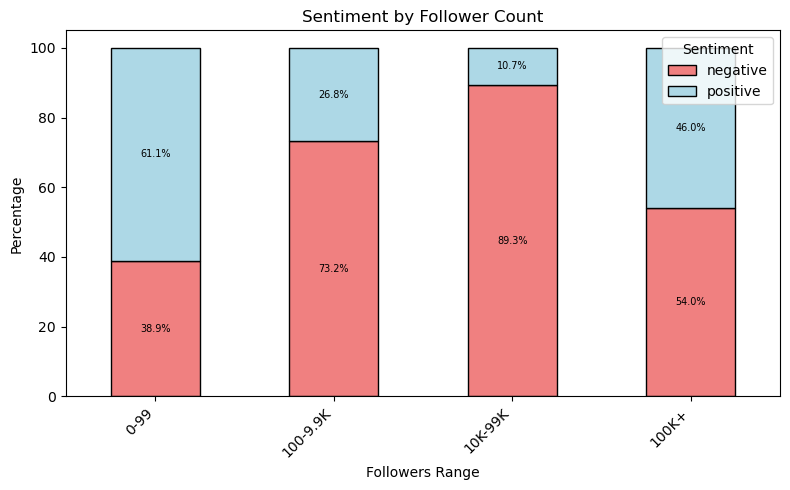

In [ ]:
# Convert 'followers' column to numeric
df['followers'] = pd.to_numeric(df['followers'], errors='coerce')

# Function to bin followers into ranges
def followers_bin(count):
    if count < 100:
        return '0-99'
    elif count < 10_000:
        return '100-9.9K'
    elif count < 100_000:
        return '10K-99K'
    else:
        return '100K+'

# Create a new category column
df['followers_range'] = df['followers'].apply(followers_bin)

# Plot sentiment distribution by follower range
plot_percentage_stacked_bar(
    df,
    category_column='followers_range',
    title='Sentiment by Follower Count',
    order=['0-99', '100-9.9K', '10K-99K', '100K+']
)


In [ ]:
# Utility: plot overlaid histograms of a numeric feature by sentiment, with optional x-limit
def plot_histogram_by_sentiment(df, feature, title=None, xlabel=None, bins=30, xlim=None):
    import matplotlib.pyplot as plt

    df_filtered = df[df['sentiment'].isin(['positive', 'negative'])].copy()

    plt.figure(figsize=(9, 4))
    plt.hist(df_filtered[df_filtered['sentiment'] == 'positive'][feature].dropna(), bins=bins,
             alpha=0.6, label='Positive', color='green', edgecolor='black', density=True)
    plt.hist(df_filtered[df_filtered['sentiment'] == 'negative'][feature].dropna(), bins=bins,
             alpha=0.6, label='Negative', color='red', edgecolor='black', density=True)

    plt.title(title or f"Distribution of {feature} by Sentiment", fontsize=14)
    plt.xlabel(xlabel or feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    if xlim:
        plt.xlim(0, xlim)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


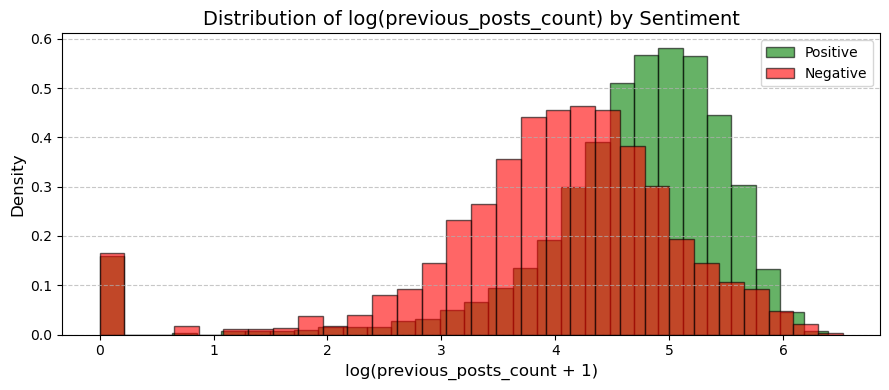

In [ ]:
# Create log feature
df['log_previous_posts'] = np.log1p(pd.to_numeric(df['previous_posts_count'], errors='coerce'))

# Plot histogram of log(previous_posts_count) by sentiment
plot_histogram_by_sentiment(
    df,
    feature='log_previous_posts',
    title="Distribution of log(previous_posts_count) by Sentiment",
    xlabel="log(previous_posts_count + 1)"
)

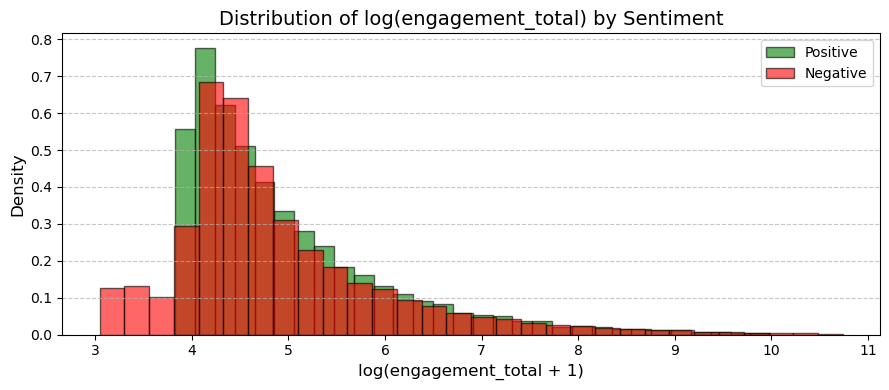

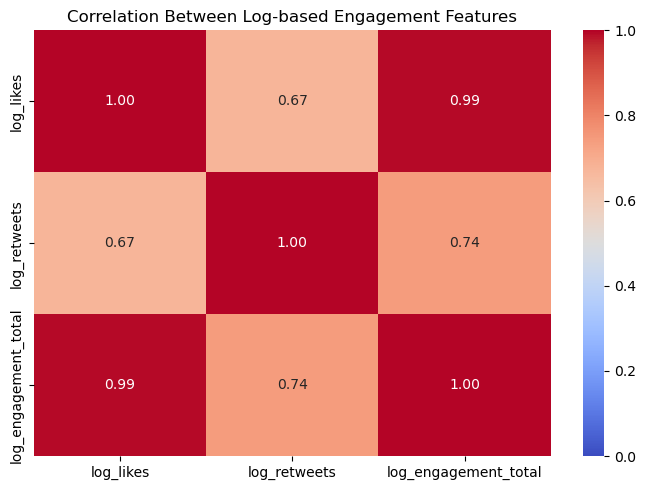

In [ ]:
# Convert columns to numeric
df['post_likes'] = pd.to_numeric(df['post_likes'], errors='coerce')
df['posts_retweets'] = pd.to_numeric(df['posts_retweets'], errors='coerce')

# Create new log-based features
df['engagement_total'] = df['post_likes'] + df['posts_retweets']
df['log_engagement_total'] = np.log1p(df['engagement_total'])
df['log_likes'] = np.log1p(df['post_likes'])
df['log_retweets'] = np.log1p(df['posts_retweets'])
# Plot histogram of log(engagement_total) by sentiment
plot_histogram_by_sentiment(
    df,
    feature='log_engagement_total',
    title="Distribution of log(engagement_total) by Sentiment",
    xlabel="log(engagement_total + 1)"
)
# Plot correlation matrix between log-based engagement features
corr_matrix = df[['log_likes', 'log_retweets', 'log_engagement_total']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.title("Correlation Between Log-based Engagement Features")
plt.tight_layout()
plt.show()


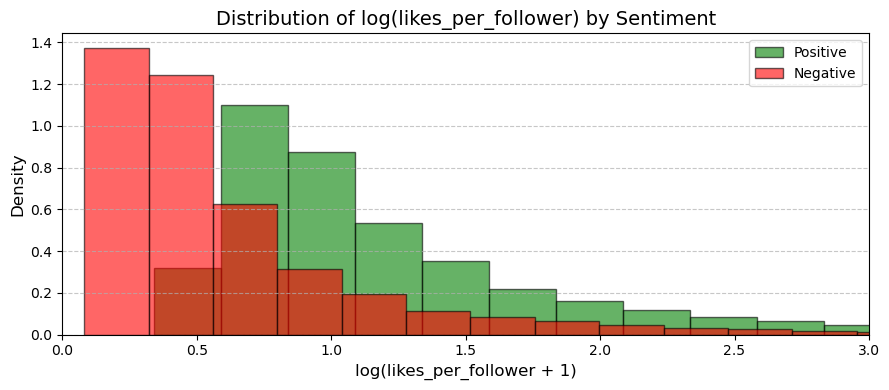

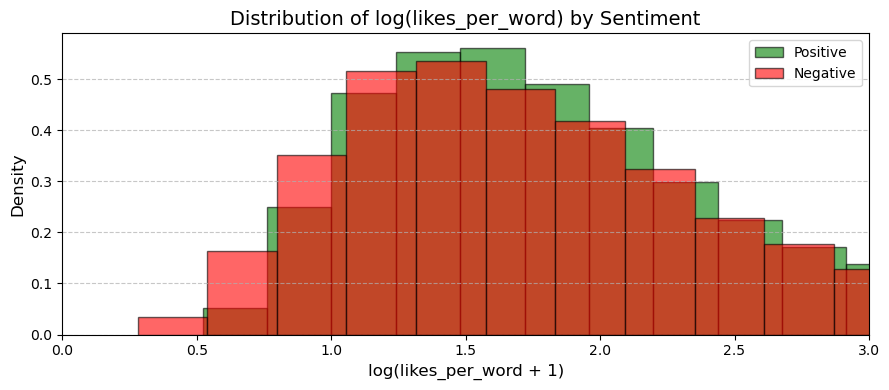

In [ ]:
# Make sure relevant columns are numeric
df['post_likes'] = pd.to_numeric(df['post_likes'], errors='coerce')
df['followers'] = pd.to_numeric(df['followers'], errors='coerce')

# If missing, create text length and make sure it's numeric
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df['text_length'] = pd.to_numeric(df['text_length'], errors='coerce')

# Create engagement ratios
df['likes_per_follower'] = df['post_likes'] / (df['followers'] + 1)  # Avoid division by zero
df['likes_per_word'] = df['post_likes'] / (df['text_length'] + 1)

# Log versions
df['log_likes_per_follower'] = np.log1p(df['likes_per_follower'])
df['log_likes_per_word'] = np.log1p(df['likes_per_word'])

# Plot
plot_histogram_by_sentiment(
    df,
    feature='log_likes_per_follower',
    title="Distribution of log(likes_per_follower) by Sentiment",
    xlabel="log(likes_per_follower + 1)",
    xlim=3
)

plot_histogram_by_sentiment(
    df,
    feature='log_likes_per_word',
    title="Distribution of log(likes_per_word) by Sentiment",
    xlabel="log(likes_per_word + 1)",
    xlim=3
)


In [ ]:
# Create binary features for post type
df['type_post'] = (df['type'] == 'post').astype(int)
df['type_reply'] = (df['type'] == 'reply').astype(int)
df['type_retweet'] = (df['type'] == 'retweet').astype(int)

# Create feature for embedded content
df['has_embedded_content'] = df['embedded_content_url'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() not in ['', '?'] else 0
)

# Create combined type-embedded feature
def map_type_embedded(row):
    if row['type_post'] == 1:
        return 'post_with_embedded' if row['has_embedded_content'] == 1 else 'post_without_embedded'
    elif row['type_reply'] == 1:
        return 'reply_with_embedded' if row['has_embedded_content'] == 1 else 'reply_without_embedded'
    elif row['type_retweet'] == 1:
        return 'retweet_with_embedded' if row['has_embedded_content'] == 1 else 'retweet_without_embedded'
    else:
        return 'other'

df['type_embedded_combo'] = df.apply(map_type_embedded, axis=1)


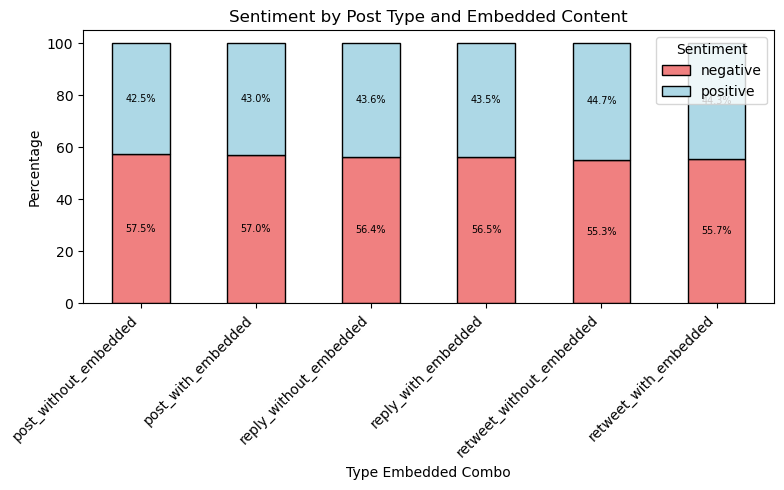

In [ ]:
# Filter only relevant categories
relevant_categories = [
    'post_with_embedded', 'post_without_embedded',
    'reply_with_embedded', 'reply_without_embedded',
    'retweet_with_embedded', 'retweet_without_embedded'
]

df_filtered = df[df['type_embedded_combo'].isin(relevant_categories)]

# Plot using existing function
plot_percentage_stacked_bar(
    df_filtered,
    category_column='type_embedded_combo',
    title='Sentiment by Post Type and Embedded Content',
    order=[
        'post_without_embedded', 'post_with_embedded',
        'reply_without_embedded', 'reply_with_embedded',
        'retweet_without_embedded', 'retweet_with_embedded'
    ]
)


In [ ]:
# Start preprocessing
df2 = pd.read_csv('sentiment.csv')
# # Convert empty or question mark values ​​to NaN
df2.replace(['?', ''], np.nan, inplace=True)
df_preprocessing = df2.copy()

In [ ]:
# Start preprocessing
df_preprocessing = df2.copy()

# Step 1 - Remove duplicates
duplicates_count = df_preprocessing.duplicated().sum()
duplicates_count  # No need to remove if none found

# Remove rows with 4 or more missing values
df_preprocessing = df_preprocessing[df_preprocessing.isnull().sum(axis=1) < 4]

# Keep only rows with valid sentiment (positive or negative)
df_preprocessing = df_preprocessing[df_preprocessing['sentiment'].isin(['positive', 'negative'])]

print("Number of rows after filtering:", df_preprocessing.shape[0])


Number of rows after filtering: 38800


In [ ]:
# Remove outliers
# Select only numeric columns
numeric_cols = df_preprocessing.select_dtypes(include=['float64', 'int64']).columns

# Simple function to remove outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply outlier removal
df_preprocessing = remove_outliers(df_preprocessing, numeric_cols)


In [ ]:
# Step 2 - Handle missing values

# Profile picture
df_preprocessing['has_profile_picture'] = df_preprocessing['profile_picture'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() != '' else 0
)

# Embedded content
df_preprocessing['has_embedded_content'] = df_preprocessing['embedded_content_url'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() not in ['', '?'] else 0
)

# Email
df_preprocessing['has_email'] = df_preprocessing['email'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() not in ['', '?'] else 0
)

# Numeric conversion for likes, followers, retweets
df_preprocessing['post_likes'] = pd.to_numeric(df_preprocessing['post_likes'], errors='coerce')
df_preprocessing['followers'] = pd.to_numeric(df_preprocessing['followers'], errors='coerce')
df_preprocessing['posts_retweets'] = pd.to_numeric(df_preprocessing['posts_retweets'], errors='coerce')

# Fill missing with medians
likes_median = df_preprocessing['post_likes'].median()
followers_median = df_preprocessing['followers'].median()
retweets_median = df_preprocessing['posts_retweets'].median()

df_preprocessing['post_likes'] = df_preprocessing['post_likes'].fillna(likes_median)
df_preprocessing['followers'] = df_preprocessing['followers'].fillna(followers_median)
df_preprocessing['posts_retweets'] = df_preprocessing['posts_retweets'].fillna(retweets_median)

# Check missing values after filling
df_preprocessing[['post_likes', 'followers', 'posts_retweets']].isnull().sum()

# Handle dates
df_preprocessing['birthday'] = pd.to_datetime(df_preprocessing['birthday'], errors='coerce')
df_preprocessing['age'] = 2025 - df_preprocessing['birthday'].dt.year

df_preprocessing['account_creation_date'] = pd.to_datetime(df_preprocessing['account_creation_date'], errors='coerce')
df_preprocessing['post_datetime'] = pd.to_datetime(df_preprocessing['post_datetime'], errors='coerce')

# Calculate account age in days
df_preprocessing['num_creation_days'] = (
    df_preprocessing['post_datetime'] - df_preprocessing['account_creation_date']
).dt.days

# Fill missing account age
median_days = df_preprocessing['num_creation_days'].median()
df_preprocessing['num_creation_days'] = df_preprocessing['num_creation_days'].fillna(median_days)

# Create new account flag
df_preprocessing['is_new_account'] = df_preprocessing['num_creation_days'] < 30

# Age re-calculation (safety)
df_preprocessing['age'] = 2025 - df_preprocessing['birthday'].dt.year

# Handle previous posts count
df_preprocessing['previous_posts_count'] = pd.to_numeric(df_preprocessing['previous_posts_count'], errors='coerce')
df_preprocessing['previous_posts_count'] = df_preprocessing['previous_posts_count'].fillna(0)


In [ ]:
# Step 3 - Convert categorical features to binary

# Sentiment to binary
df_preprocessing['sentiment_binary'] = df_preprocessing['sentiment'].map({'positive': 1, 'negative': 0})

# Type of post
df_preprocessing['type_post'] = (df_preprocessing['type'] == 'post').astype(int)
df_preprocessing['type_reply'] = (df_preprocessing['type'] == 'reply').astype(int)
df_preprocessing['type_retweet'] = (df_preprocessing['type'] == 'retweet').astype(int)

# Embedded content presence
df_preprocessing['has_embedded_content'] = df_preprocessing['embedded_content_url'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() not in ['', '?'] else 0
)

# Profile picture presence
df_preprocessing['has_profile_picture'] = df_preprocessing['profile_picture'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() != '' else 0
)

# Email presence
df_preprocessing['has_email'] = df_preprocessing['email'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() not in ['', '?'] else 0
)


In [ ]:
# Step 4 - Feature extraction (text features)

from sklearn.feature_extraction.text import TfidfVectorizer

# Number of hashtags
df_preprocessing['num_of_hashtag'] = df_preprocessing['text'].apply(
    lambda x: x.count('#') if isinstance(x, str) else 0
)

# Text length (in words)
df_preprocessing['text_length'] = df_preprocessing['text'].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0
)

# Clean text for TF-IDF
df_preprocessing['cleaned_text'] = df_preprocessing['text'].fillna('').str.lower()

# TF-IDF vectorization (top 200 features)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=200)
tfidf_matrix = vectorizer.fit_transform(df_preprocessing['cleaned_text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df_preprocessing.index)

# Remove duplicate columns (if any)
tfidf_df_unique = tfidf_df.loc[:, ~tfidf_df.columns.duplicated()]

# Select top 40 features
tfidf_df_selected = tfidf_df_unique.iloc[:, :40]

# Merge TF-IDF features into main DataFrame
df_preprocessing = pd.concat([df_preprocessing, tfidf_df_selected], axis=1)

print("Selected 40 TF-IDF features:")
print(tfidf_df_selected.columns.tolist())


Selected 40 TF-IDF features:
['able', 'accepted', 'actually', 'afraid', 'agitated', 'angry', 'anxious', 'away', 'bad', 'best', 'better', 'bit', 'blessed', 'blog', 'body', 'book', 'care', 'cold', 'come', 'completely', 'confidenceboost', 'day', 'days', 'did', 'didn', 'didnt', 'didnt feel', 'doing', 'don', 'don feel', 'dont', 'dont know', 'end', 'especially', 'excited', 'face', 'fact', 'family', 'far', 'feel']


In [ ]:
# Step 5 - Map timezones and extract time features

# Timezone to UTC offset mapping
timezone_map = {
    'UTC': 0, 'GMT': 0, 'CET': 1, 'EET': 2, 'MSK': 3,
    'EST': -5, 'PST': -8, 'AEST': 10, 'KST': 9, 'JST': 9
}

# Map timezone offsets
df_preprocessing['timezone_offset'] = df_preprocessing['timezone'].map(timezone_map)

# Parse post datetime
df_preprocessing['post_datetime'] = pd.to_datetime(df_preprocessing['post_datetime'], errors='coerce')

# Calculate UTC and local post hours
df_preprocessing['utc_hour'] = df_preprocessing['post_datetime'].dt.hour
df_preprocessing['local_hour'] = (df_preprocessing['utc_hour'] + df_preprocessing['timezone_offset']) % 24

# Classify time of day
def classify_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'noon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df_preprocessing['time_of_day'] = df_preprocessing['local_hour'].apply(classify_time)

# One-hot encode time of day
df_preprocessing = pd.get_dummies(df_preprocessing, columns=['time_of_day'])

# Convert dummies to int
for col in df_preprocessing.columns:
    if col.startswith('time_of_day_'):
        df_preprocessing[col] = df_preprocessing[col].astype(int)

# Extract day of the week
df_preprocessing['day_of_week'] = df_preprocessing['post_datetime'].dt.dayofweek

# Weekend indicator
df_preprocessing['is_weekend'] = df_preprocessing['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)


In [ ]:
# Step 6 - Followers binning and encoding

# Ensure followers column is numeric
# followers
df_preprocessing['followers'] = pd.to_numeric(df_preprocessing['followers'], errors='coerce')

def followers_bin(count):
    if count < 100:
        return 'tiny'
    elif count < 10000:
        return 'mid'
    elif count < 100000:
        return 'large'
    else:
        return None

df_preprocessing['followers_level'] = df_preprocessing['followers'].apply(followers_bin)

df_preprocessing = df_preprocessing[df_preprocessing['followers_level'].notna()]

df_preprocessing = pd.get_dummies(df_preprocessing, columns=['followers_level'], prefix='followers_level')


In [ ]:
#previous_posts_count,post_likes, posts_retweets
df_preprocessing['previous_posts_count'] = pd.to_numeric(df_preprocessing['previous_posts_count'], errors='coerce')
df_preprocessing['post_likes'] = pd.to_numeric(df_preprocessing['post_likes'], errors='coerce')
df_preprocessing['posts_retweets'] = pd.to_numeric(df_preprocessing['posts_retweets'], errors='coerce')

df_preprocessing['log_previous_posts'] = np.log1p(df_preprocessing['previous_posts_count'])

df_preprocessing['engagement_total'] = df_preprocessing['post_likes'] + df_preprocessing['posts_retweets']
df_preprocessing['log_engagement_total'] = np.log1p(df_preprocessing['engagement_total'])

#checkmark
df_preprocessing = pd.get_dummies(df_preprocessing, columns=['checkmark'], prefix='checkmark')
df_preprocessing['checkmark_grey_or_gold'] = df_preprocessing[['checkmark_gold', 'checkmark_grey']].max(axis=1)


In [ ]:
# (Optional) Step - Build a combo feature for followers and profile picture

# Make sure columns are numeric
df_preprocessing['previous_posts_count'] = pd.to_numeric(df_preprocessing['previous_posts_count'], errors='coerce')
df_preprocessing['followers'] = pd.to_numeric(df_preprocessing['followers'], errors='coerce')

# Create feature: has profile picture
df_preprocessing['has_profile_picture'] = df_preprocessing['profile_picture'].apply(
    lambda x: 'yes' if isinstance(x, str) and x.strip() != '' else 'no'
)

# Create feature: few vs. lots of followers
df_preprocessing['few_followers'] = df_preprocessing['followers'].apply(
    lambda x: 'lowfollowers' if pd.notnull(x) and x < 100 else 'lotsfollowers'
)

# Build combo feature
df_preprocessing['combo_followers_profile'] = (
    df_preprocessing['few_followers'] + '_' +
    df_preprocessing['has_profile_picture'].map({'yes': 'yesprofile', 'no': 'noprofile'})
)


In [ ]:
# Step 8 - Build combo features for profile picture and username in email

# Has profile picture
df_preprocessing['has_profile_picture'] = df_preprocessing['profile_picture'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip() != '' else 0
)

# Username appears in email (0/1)
df_preprocessing['username_in_email'] = df_preprocessing.apply(
    lambda row: row['username'].strip('@').lower() in row['email'].lower() if isinstance(row['email'], str) else False,
    axis=1
).astype(int)

# Build combo feature for username in email + profile picture
def create_combo(row):
    if row['username_in_email'] == 0 and row['has_profile_picture'] == 0:
        return 'no_userbyemail_no_profile'
    elif row['username_in_email'] == 0 and row['has_profile_picture'] == 1:
        return 'no_userbyemail_yes_profile'
    elif row['username_in_email'] == 1 and row['has_profile_picture'] == 0:
        return 'yes_userbyemail_no_profile'
    else:
        return 'yes_userbyemail_yes_profile'

df_preprocessing['combo_username_email_profile'] = df_preprocessing.apply(create_combo, axis=1)

# Create binary flags from the combo
df_preprocessing['is_no_userbyemail_no_profile'] = (df_preprocessing['combo_username_email_profile'] == 'no_userbyemail_no_profile').astype(int)
df_preprocessing['is_no_userbyemail_yes_profile'] = (df_preprocessing['combo_username_email_profile'] == 'no_userbyemail_yes_profile').astype(int)
df_preprocessing['is_yes_userbyemail_no_profile'] = (df_preprocessing['combo_username_email_profile'] == 'yes_userbyemail_no_profile').astype(int)
df_preprocessing['is_yes_userbyemail_yes_profile'] = (df_preprocessing['combo_username_email_profile'] == 'yes_userbyemail_yes_profile').astype(int)

# Also create binary flags from followers+profile picture combo
df_preprocessing['is_lowfollowers_noprofile'] = (df_preprocessing['combo_followers_profile'] == 'lowfollowers_noprofile').astype(int)
df_preprocessing['is_lowfollowers_yesprofile'] = (df_preprocessing['combo_followers_profile'] == 'lowfollowers_yesprofile').astype(int)
df_preprocessing['is_lotsfollowers_noprofile'] = (df_preprocessing['combo_followers_profile'] == 'lotsfollowers_noprofile').astype(int)
df_preprocessing['is_lotsfollowers_yesprofile'] = (df_preprocessing['combo_followers_profile'] == 'lotsfollowers_yesprofile').astype(int)


In [ ]:
# Step 9 - New feature creation

# Create ratios
threshold = 0.7  # Threshold can be adjusted
df_preprocessing['likes_per_follower'] = df_preprocessing['post_likes'] / (df_preprocessing['followers'] + 1)
df_preprocessing['likes_per_word'] = df_preprocessing['post_likes'] / (df_preprocessing['text_length'] + 1)

# Log transform ratios
df_preprocessing['log_likes_per_follower'] = np.log1p(df_preprocessing['likes_per_follower'])
df_preprocessing['log_likes_per_word'] = np.log1p(df_preprocessing['likes_per_word'])

# Create binary feature: high log_likes_per_follower
df_preprocessing['log_likes_per_follower'] = (df_preprocessing['log_likes_per_follower'] > threshold).astype(int)

# Followers relative to age
df_preprocessing['followers_per_age'] = df_preprocessing['followers'] / (df_preprocessing['age'] + 1)
df_preprocessing['log_followers_per_age'] = np.log1p(df_preprocessing['followers']) / (df_preprocessing['age'] + 1)

# Short positive text
df_preprocessing['short_text_positive'] = (
    (df_preprocessing['text_length'] < 10) & (df_preprocessing['sentiment'] == 'positive')
).astype(int)

# Long negative text
df_preprocessing['long_text_negative'] = (
    (df_preprocessing['text_length'] > 30) & (df_preprocessing['sentiment'] == 'negative')
).astype(int)


In [ ]:

feature_columns = [
    'sentiment_binary',
    'num_of_hashtag', 'text_length',
    'type_post', 'type_reply', 'type_retweet',
    'time_of_day_morning', 'time_of_day_noon', 'time_of_day_evening', 'time_of_day_night', 'is_weekend',
    'followers_level_tiny', 'followers_level_mid', 'followers_level_large',
    'log_previous_posts', 'log_engagement_total',
    'has_profile_picture', 'has_email', 'has_embedded_content',
    'checkmark_blue', 'checkmark_gold', 'checkmark_grey', 'checkmark_none', 'checkmark_grey_or_gold',
    'num_creation_days', 'is_new_account', 'age','is_no_userbyemail_no_profile',
    'is_no_userbyemail_yes_profile','is_yes_userbyemail_no_profile','is_yes_userbyemail_yes_profile',
    'is_lowfollowers_noprofile','is_lowfollowers_yesprofile',
    'is_lotsfollowers_noprofile','is_lotsfollowers_yesprofile',
    'log_likes_per_follower','log_followers_per_age',
    'short_text_positive','long_text_negative'
]

feature_columns += list(tfidf_df_selected.columns)
df_features = df_preprocessing[feature_columns].copy()

In [ ]:

continuous_features = [
    'num_of_hashtag', 'text_length',
    'log_previous_posts', 'log_engagement_total',
    'num_creation_days', 'age'
] + list(tfidf_df_selected.columns)


bool_cols = df_features.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df_features[col] = df_features[col].astype(int)
#0-1
scaler = MinMaxScaler()
df_features[continuous_features] = scaler.fit_transform(df_features[continuous_features])

In [ ]:
X = df_features.drop(columns=['sentiment_binary'])
y = df_features['sentiment_binary']

scores = []
for feature in X.columns:
    pos_values = X[feature][y == 1]
    neg_values = X[feature][y == 0]

    mu_pos = pos_values.mean()
    mu_neg = neg_values.mean()
    std_pos = pos_values.std()
    std_neg = neg_values.std()

    denominator = std_pos + std_neg

    if denominator == 0:
        R = np.nan
    else:
        R = abs(mu_pos - mu_neg) / denominator

    scores.append((feature, R))

fisher_score_manual = pd.DataFrame(scores, columns=['Feature', 'R_score'])
fisher_score_manual_sorted = fisher_score_manual.sort_values(by='R_score', ascending=False)
print(fisher_score_manual_sorted.head(30))

                           Feature   R_score
34          log_likes_per_follower  0.626977
0                   num_of_hashtag  0.552269
37              long_text_negative  0.443400
10            followers_level_tiny  0.373353
11             followers_level_mid  0.362310
22          checkmark_grey_or_gold  0.345742
35           log_followers_per_age  0.314309
36             short_text_positive  0.310773
31      is_lowfollowers_yesprofile  0.308768
32      is_lotsfollowers_noprofile  0.288800
13              log_previous_posts  0.267894
19                  checkmark_gold  0.229542
20                  checkmark_grey  0.229484
21                  checkmark_none  0.197721
26    is_no_userbyemail_no_profile  0.163816
33     is_lotsfollowers_yesprofile  0.163804
5              time_of_day_morning  0.155674
15             has_profile_picture  0.153365
29  is_yes_userbyemail_yes_profile  0.119159
27   is_no_userbyemail_yes_profile  0.114442
1                      text_length  0.113425
50        

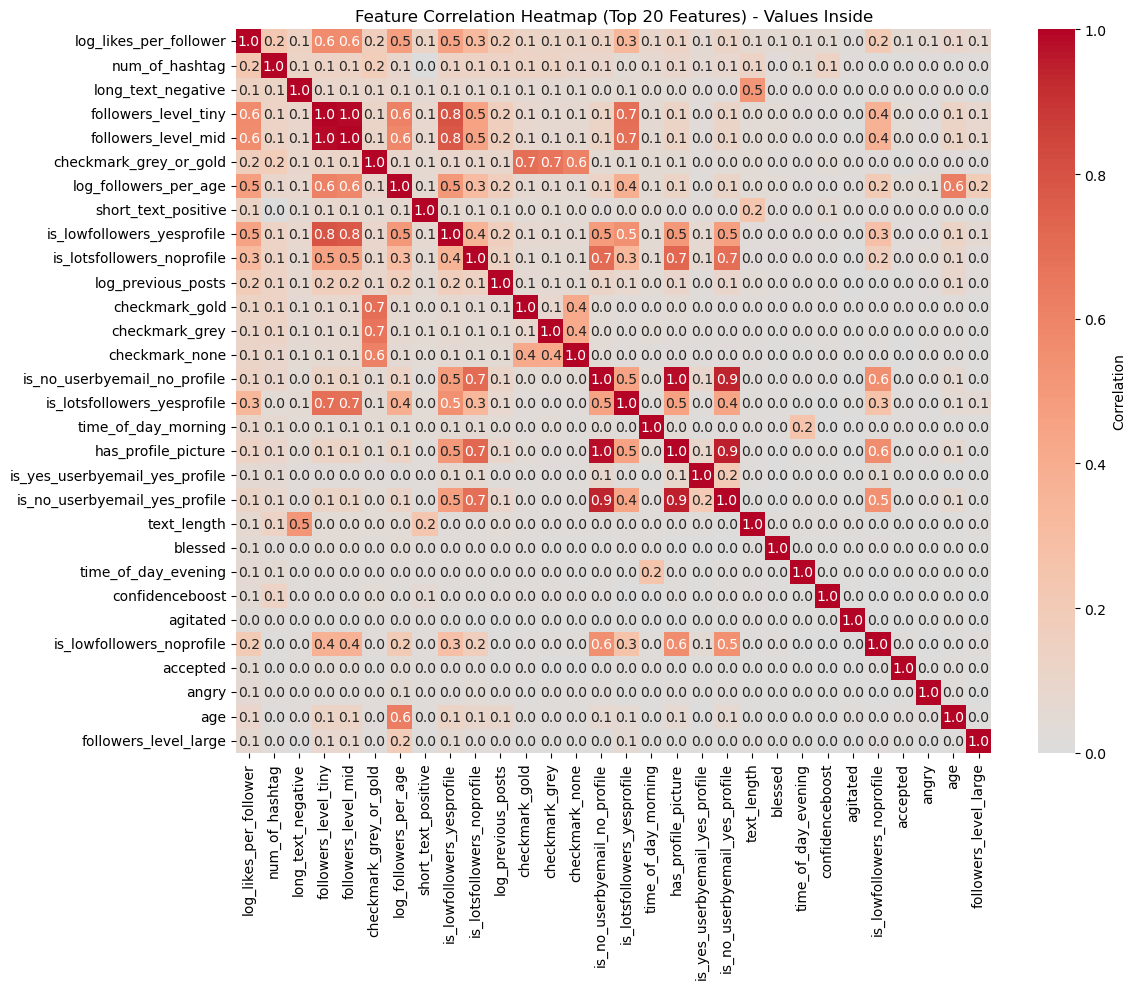


Highly correlated feature pairs (>0.9):

followers_level_mid  <-->  followers_level_tiny : Correlation = 0.99
has_profile_picture  <-->  is_no_userbyemail_no_profile : Correlation = 0.98
is_no_userbyemail_yes_profile  <-->  is_no_userbyemail_no_profile : Correlation = 0.94
is_no_userbyemail_yes_profile  <-->  has_profile_picture : Correlation = 0.95

Recommended features to drop to avoid redundancy:
['is_no_userbyemail_yes_profile', 'followers_level_mid', 'has_profile_picture']


In [ ]:
top_k = 30

# Fix: need to select a column when sorting
selected_features = fisher_score_manual_sorted.head(top_k)['Feature'].tolist()

# Select top features from X
X_selected = X[selected_features]

# Correlation matrix
corr_matrix = X_selected.corr().round(2).abs()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.1f', cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap (Top 20 Features) - Values Inside')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs

# Keep upper triangle of the matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.9
to_drop = []

# Map feature to its Fisher score
fisher_series = dict(zip(fisher_score_manual_sorted['Feature'], fisher_score_manual_sorted['R_score']))

print("\nHighly correlated feature pairs (>0.9):\n")
for col in upper_tri.columns:
    high_corr = upper_tri[col][upper_tri[col] > threshold]
    for idx in high_corr.index:
        print(f"{col}  <-->  {idx} : Correlation = {upper_tri[col][idx]:.2f}")
        # Keep feature with the higher Fisher score
        if fisher_series[col] >= fisher_series[idx]:
            to_drop.append(idx)
        else:
            to_drop.append(col)

# Final list of features to drop
to_drop = list(set(to_drop))
print("\nRecommended features to drop to avoid redundancy:")
print(to_drop)


In [ ]:
#selection
feature_list = [
    'log_likes_per_follower',
    'num_of_hashtag',
    'long_text_negative',
    'followers_level_tiny',
    'checkmark_grey_or_gold',
    'log_followers_per_age',
    'short_text_positive',
    'is_lowfollowers_yesprofile',
    'is_lotsfollowers_noprofile',
    'log_previous_posts',
    'checkmark_gold',
    'checkmark_grey',
    'checkmark_none',
    'is_lotsfollowers_yesprofile',
    'is_no_userbyemail_no_profile',
    'time_of_day_morning',
    'text_length',
    'blessed',
    'time_of_day_evening',
    'confidenceboost',
    'agitated',
    'accepted',
    'angry'
]

print("selected features:")
print(selected_features)

selected features:
['log_likes_per_follower', 'num_of_hashtag', 'long_text_negative', 'followers_level_tiny', 'followers_level_mid', 'checkmark_grey_or_gold', 'log_followers_per_age', 'short_text_positive', 'is_lowfollowers_yesprofile', 'is_lotsfollowers_noprofile', 'log_previous_posts', 'checkmark_gold', 'checkmark_grey', 'checkmark_none', 'is_no_userbyemail_no_profile', 'is_lotsfollowers_yesprofile', 'time_of_day_morning', 'has_profile_picture', 'is_yes_userbyemail_yes_profile', 'is_no_userbyemail_yes_profile', 'text_length', 'blessed', 'time_of_day_evening', 'confidenceboost', 'agitated', 'is_lowfollowers_noprofile', 'accepted', 'angry', 'age', 'followers_level_large']
